# Two dimensional heatmap : empirical scaling d and affinity (y)

## Imports

In [1]:
import sys
import os
import os.path
import io
import csv
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy import integrate
import seaborn as sns
import numpy.random as nprand

# plt.rcParams.update({'font.size': 16})
from scipy.stats import gamma

In [2]:
init_path="../../../"

## Read files

In [3]:
def readfiles1(pathtofile, file_name, ext_name,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    nbline=1
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                if nbline>=line_to_begin:
                    for j in range(len(lin)):
                        if ext_name == "allele":
                            if float(lin[5])>minq and float(lin[6])>minfert:
                                if withoutneutral==1 and float(lin[1]) != -3 :
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j])) 
                                elif withoutneutral==0:
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j]))
                        elif ext_name == "trace" and logfert==True and (j==6 or j==14):
                            data[params[j]].append(np.log(float(lin[j])))
                        else :
                            data[params[j]].append(float(lin[j]))
                nbline=nbline+1
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
                nbline=nbline+1
    return (data)

In [4]:
def readparamsfile(pathtofile, file_name, ext_name):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        for line in reader:
            lin = line[0].split()
            data[lin[0]]=[]
            data[lin[0]].append(float(lin[1]))
    return (data)

## General parameters

In [5]:
N=5000
h=400
d=6
coeff_gamma=0.6
c=1

## Useful functions

In [6]:
def dico_data(target_folder_path,x_params,y_params, file_ext, withneutral,withoutnan,withlog,initline):
    list_files = sorted(os.listdir(target_folder_path))
    dico_file = dict()
    list_namefile=[]
    for file_name in list_files :
        if file_name.split(".")[1]==file_ext :
            if withneutral==1:
                data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],0,withoutnan)
            elif withneutral==0:
                data_file=readfiles1(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],1,withoutnan,0,0,withlog,initline)
            if  x_params in data_file and y_params in data_file :
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_x_params"]=data_file[x_params]
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_y_params"]=data_file[y_params]
            list_namefile.append((file_name.split(".")[0]).split("_")[2])
    list_namefile=sorted(list(set(list_namefile)))
    return (list_namefile,dico_file)

In [7]:
def simpson(f, a, b, n,coeff_gamma,c):
    pas = (b - a) / n
    somme = (f(a,coeff_gamma,c) + f(b,coeff_gamma,c)) / 2 + 2 * f(a + pas / 2,coeff_gamma,c)  # On initialise la somme
    x = a + pas           # La somme commence à x_1 
    for i in range(1, n): # On calcule la somme 
        somme += f(x,coeff_gamma,c) + 2 * f(x + pas / 2,coeff_gamma,c)
        x += pas
    return somme * pas / 3   # On retourne cette somme fois le pas / 3  

def gamma_func(aff,coeff_gamma):
    integral=1/coeff_gamma*np.exp(-aff*1/coeff_gamma)
    return integral

def x_0_func(aff,coeff_gamma,c):
    integral=(c*aff)/(1+c*aff)*gamma_func(aff,coeff_gamma)
    return integral
def x2_0_func(aff,coeff_gamma,c):
    integral=((c*aff)/(1+c*aff))**2*gamma_func(aff,coeff_gamma)
    return integral
def x3_0_func(aff,coeff_gamma,c):
    integral=((c*aff)/(1+c*aff))**3*gamma_func(aff,coeff_gamma)
    return integral
def x4_0_func(aff,coeff_gamma,c):
    integral=((c*aff)/(1+c*aff))**4*gamma_func(aff,coeff_gamma)
    return integral

In [8]:
x_0=simpson(x_0_func, 0, 100, 1000,coeff_gamma,c)
x2_0=simpson(x2_0_func, 0, 100, 1000,coeff_gamma,c)
x3_0=simpson(x3_0_func, 0, 100, 1000,coeff_gamma,c)
x4_0=simpson(x4_0_func, 0, 100, 1000,coeff_gamma,c)
q_0=(2*x2_0-x3_0)/(x_0)
w_0=1-np.exp(-d*q_0)
beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
alpha=abs((1/w_0)*d*beta_0*np.exp(-d*q_0))

In [9]:
def s0_def(list_namefile_age,dico_file_age,list_namefile_freq,dico_file_freq):
    S0=[]
    for i in list_namefile_age :
        fert_moy=0
        n=len(dico_file_age[i+"_x_params"])
        m=min(dico_file_age[i+"_x_params"])
        ntot=0
        for j in range(n):
            if dico_file_age[i+"_x_params"][j]==m and dico_file_age[i+"_y_params"][j]!=0:
                fert_moy+=dico_file_age[i+"_y_params"][j]
                ntot+=1
        fertility_new_all=fert_moy/ntot
        meanfert=0
        for j in range(len(dico_file_age[i+"_y_params"])):
            meanfert=meanfert+dico_file_freq[i+"_y_params"][j]*dico_file_freq[i+"_x_params"][j]
        fert_moy=np.log(fert_moy/ntot)-np.log(np.mean(dico_file_age[i+"_y_params"]))
        S0.append(fert_moy)
    return(S0)

In [10]:
def sigmatau_def(u,v,d,coeff_gamma,c,target_folder_path,file_name,sig):
    x_0=simpson(x_0_func, 0, 100, 1000,coeff_gamma,c)
    x2_0=simpson(x2_0_func, 0, 100, 1000,coeff_gamma,c)
    x3_0=simpson(x3_0_func, 0, 100, 1000,coeff_gamma,c)
    x4_0=simpson(x4_0_func, 0, 100, 1000,coeff_gamma,c)
    q_0=(2*x2_0-x3_0)/(x_0)
    w_0=1-np.exp(-d*q_0)
    beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
    alpha=abs((1/w_0)*d*beta_0*np.exp(-d*q_0))############################
    rho=(N*v*d)/(2*h)
    mu=4*N*u
    z_bar=np.sqrt(rho/(mu*alpha))
    DTau=np.sqrt(mu/(rho*alpha))
    Tau=2*np.sqrt(1/(rho*mu*alpha))
    s0=alpha*z_bar/2
    if sig==1:
        sigma=float(readparamsfile(target_folder_path, file_name, 'params')['sigma_0'][0])
    else :
        sigma=float(readparamsfile(target_folder_path, file_name, 'params')['Sigma_0'][0])
    return(sigma*Tau,Tau,sigma,s0)

## Heatmap function

In [11]:
withoutneutral=0
logfert=0
key="Diversity"
key1="q"
key2="Fertility_rate"
key3="cfree_ctot_hom"
key4="cfree_ctot_het"
key5="Mean_c_free_het"
key6="Mean_c_free_hom"
key7="Activity"
key8="mean_affinity"
key9="Mean_sigma"
init_line=100
c=1
def heatmap_Div_ctot(target_folder_path, key, logfert, withoutneutral, init_line,c):
    list_dir = sorted(os.listdir(target_folder_path))
    data = dict()
    sigmatau = dict()
    Nu = dict()
    sigdtau = dict()
    tau = dict()
    sig0 = dict()
    Ns0 = dict()
    fourNs0 = dict()
    q=dict()
    fert=dict()
    sigma=dict()
    tau=dict()
    cfree_ctot_hom=dict()
    cfree_ctot_het=dict()
    cfree_hom=dict()
    cfree_het=dict()
    q_0_hom=dict()
    q_0_het=dict()
    Mean_cfree_het=dict()
    Mean_cfree_hom=dict()
    cfree_aff_het=dict()
    cfree_aff_hom=dict()
    activity=dict()
    mean_affinity=dict()
    cfree_meanaff_eq_het=dict()
    cfree_meanaff_eq_hom=dict()
    sigma_z=dict()
    col_names=[]
    list_index=[]
    first_loop=0
    for dir_name in list_dir :
        list_index=[]
        data[float(dir_name.split("_")[2])]=[]
        sigmatau[float(dir_name.split("_")[2])]=[]
        sigma[float(dir_name.split("_")[2])]=[]
        Nu[float(dir_name.split("_")[2])]=[]
        sigdtau[float(dir_name.split("_")[2])] = []
        tau[float(dir_name.split("_")[2])] = []
        sig0[float(dir_name.split("_")[2])] = []
        Ns0[float(dir_name.split("_")[2])] = []
        q[float(dir_name.split("_")[2])]=[]
        fert[float(dir_name.split("_")[2])]=[]
        tau[float(dir_name.split("_")[2])]=[]
        cfree_ctot_hom[float(dir_name.split("_")[2])]=[]
        cfree_ctot_het[float(dir_name.split("_")[2])]=[]
        cfree_hom[float(dir_name.split("_")[2])]=[]
        cfree_het[float(dir_name.split("_")[2])]=[]
        Mean_cfree_het[float(dir_name.split("_")[2])]=[]
        Mean_cfree_hom[float(dir_name.split("_")[2])]=[]
        cfree_aff_het[float(dir_name.split("_")[2])]=[]
        cfree_aff_hom[float(dir_name.split("_")[2])]=[]
        activity[float(dir_name.split("_")[2])]=[]
        mean_affinity[float(dir_name.split("_")[2])]=[]
        cfree_meanaff_eq_het[float(dir_name.split("_")[2])]=[]
        cfree_meanaff_eq_hom[float(dir_name.split("_")[2])]=[]
        sigma_z[float(dir_name.split("_")[2])]=[]
        col_names.append(float((dir_name.split(".")[0]).split("_")[2]))
        list_files = sorted(os.listdir(target_folder_path+'/'+dir_name))
        list_namefile,dico_file=dico_data(target_folder_path+'/'+dir_name+'/',"Age","fertility_analytic","allele",0,1,False,0)
        list_namefile1,dico_file1=dico_data(target_folder_path+'/'+dir_name+'/',"Frequency","fertility_analytic","allele",0,1,False,0)
        for files_name in list_files :
            if files_name.split(".")[-1]=="trace":
                if files_name.split(".")[1]=="trace":
                    filename=files_name.split(".")[0]
                elif files_name.split(".")[1]!="trace":
                    filename=files_name.split(".")[0]+'.'+files_name.split(".")[1]
                list_index.append(float(filename.split("_")[2]))
                data_file = readfiles1(target_folder_path+'/'+dir_name+'/', filename, files_name.split(".")[-1],withoutneutral,0,0,0,logfert,0)
                data[float(dir_name.split("_")[2])].append(np.mean(data_file[key][init_line:]))
                sigmatau[float(dir_name.split("_")[2])].append(sigmatau_def(float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['u'][0]),float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['v'][0]),float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['nbDSB'][0]),float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['meanaff'][0]),c,target_folder_path+'/'+dir_name+'/',filename,1)[0])
                q[float(dir_name.split("_")[2])].append(np.mean(data_file[key1][init_line:]))
                sigma[float(dir_name.split("_")[2])].append(float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['sigma_0'][0]))
                fert[float(dir_name.split("_")[2])].append(np.mean(data_file[key2][init_line:]))
                tau[float(dir_name.split("_")[2])].append(sigmatau_def(float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['u'][0]),float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['v'][0]),float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['nbDSB'][0]),float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['meanaff'][0]),c,target_folder_path+'/'+dir_name+'/',filename,1)[2])
                Mean_cfree_het[float(dir_name.split("_")[2])].append(np.mean(data_file[key5][init_line:]))
                Mean_cfree_hom[float(dir_name.split("_")[2])].append(np.mean(data_file[key6][init_line:]))
                cfree_aff_het[float(dir_name.split("_")[2])].append(np.mean(data_file[key5][init_line:])*float(filename.split("_")[2]))
                cfree_aff_hom[float(dir_name.split("_")[2])].append(np.mean(data_file[key6][init_line:])*float(filename.split("_")[2]))
                activity[float(dir_name.split("_")[2])].append(np.mean(data_file[key7][init_line:]))
                sigma_z[float(dir_name.split("_")[2])].append(np.mean(data_file[key9][init_line:]))
            if files_name.split(".")[-1]=="allele":
                if files_name.split(".")[1]=="allele":
                    filename=files_name.split(".")[0]
                elif files_name.split(".")[1]!="allele":
                    filename=files_name.split(".")[0]+'.'+files_name.split(".")[1]
                data_file = readfiles1(target_folder_path+'/'+dir_name+'/', filename, files_name.split(".")[-1],withoutneutral,0,0,0,logfert,0)
                cfree_ctot_hom[float(dir_name.split("_")[2])].append(np.mean(data_file[key3][init_line:]))
                cfree_ctot_het[float(dir_name.split("_")[2])].append(np.mean(data_file[key4][init_line:])) 
                cfree_hom[float(dir_name.split("_")[2])].append((np.mean(data_file[key3][init_line:]))*float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['ctot'][0])*2)
                cfree_het[float(dir_name.split("_")[2])].append((np.mean(data_file[key4][init_line:]))*float(readparamsfile(target_folder_path+'/'+dir_name+'/', filename, 'params')['ctot'][0]))
                mean_affinity[float(dir_name.split("_")[2])].append((np.mean(data_file[key8][init_line:])))
    for cle, valeur in Mean_cfree_het.items():
        for indexvaleur in range(len(Mean_cfree_het[cle])):
            cfree_meanaff_eq_het[cle].append(Mean_cfree_het[cle][indexvaleur]*mean_affinity[cle][indexvaleur])
            cfree_meanaff_eq_hom[cle].append(Mean_cfree_hom[cle][indexvaleur]*mean_affinity[cle][indexvaleur])
            
    return (data,col_names,list_index,sigmatau,Nu,sigdtau,tau,sig0,Ns0,fourNs0,q,sigma,fert,tau,cfree_ctot_hom,cfree_ctot_het,cfree_hom,cfree_het,Mean_cfree_het,Mean_cfree_hom,cfree_aff_het,cfree_aff_hom,activity,cfree_meanaff_eq_het,cfree_meanaff_eq_hom,sigma_z,mean_affinity)

## Data storage

In [12]:
target_folder_path=init_path+"analyses/scaling_bidim_ctot_aff/scaling_bidim_ctot_aff_2"
(data,col_names,list_index,sigmatau,Nu,sigdtau,tau,sig0,Ns0,fourNs0,q,sigma,fert,tau,cfree_ctot_hom,cfree_ctot_het,cfree_hom,cfree_het,Mean_cfree_het,Mean_cfree_hom,cfree_aff_het,cfree_aff_hom,activity,cfree_meanaff_eq_het,cfree_meanaff_eq_hom,sigma_z,mean_affinity)=heatmap_Div_ctot(target_folder_path, key, logfert, withoutneutral, init_line,c)

/tmp/ipykernel_7861/2001762035.py:6: RuntimeWarning: invalid value encountered in double_scalars
  q_0=(2*x2_0-x3_0)/(x_0)
/tmp/ipykernel_7861/2001762035.py:8: RuntimeWarning: invalid value encountered in double_scalars
  beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
/tmp/ipykernel_7861/2001762035.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
/tmp/ipykernel_7861/2001762035.py:15: RuntimeWarning: invalid value encountered in double_scalars
  s0=alpha*z_bar/2


## Heatmap

Text(195.72222222222223, 0.5, 'Total PRDM9 concentration')

<Figure size 640x480 with 0 Axes>

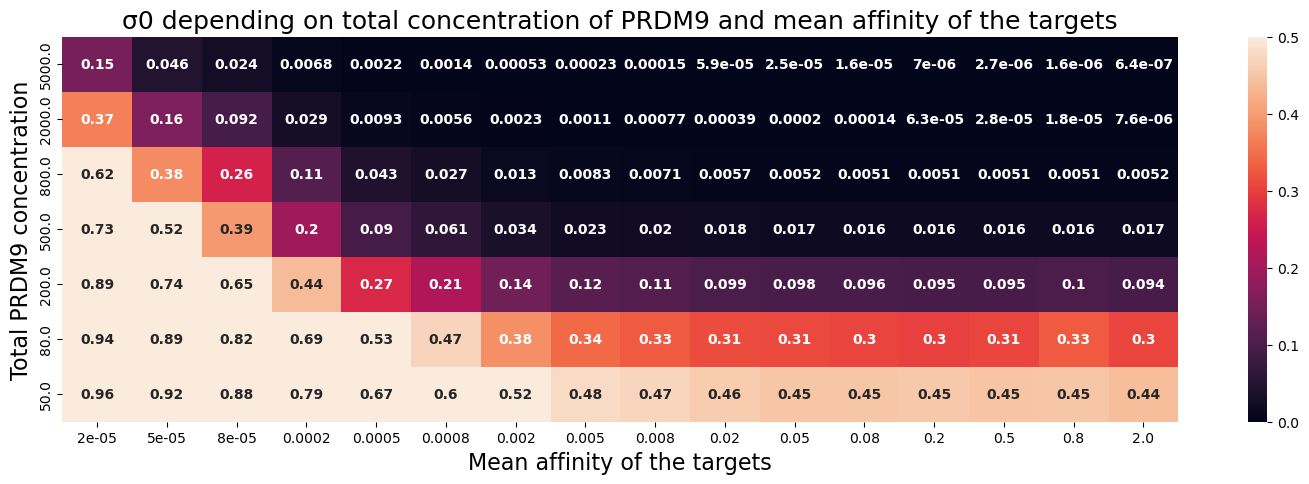

In [32]:
figure=plt.figure()
figure, axs = plt.subplots(figsize=(18,5)) #16,7
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)
df_sigma_0 = pd.DataFrame(sigma, index = list_index)
df_sigma_0_tranposed = df_sigma_0.transpose()
df_sigma_0_tranposed=df_sigma_0_tranposed.sort_index(axis = 0,ascending = False)
df_sigma_0_tranposed=df_sigma_0_tranposed.sort_index(axis = 1,ascending = True)
ax = sns.heatmap(df_sigma_0_tranposed,annot=True,vmin=0,vmax=0.5, annot_kws={"weight": "bold",'size': 10}, fmt='.2g')
ax.set_title("σ0 depending on total concentration of PRDM9 and mean affinity of the targets", fontsize=18)
ax.set_xlabel('Mean affinity of the targets',fontsize=16)
ax.set_ylabel('Total PRDM9 concentration',fontsize=16)

**Caption : Homozygotes selection coefficient associated to genetic dosage (σ0) depending on the
total PRDM9 concentration in the cell and the mean affinity of the target sites.** The σ0 is all the
greater as the concentration of PRDM9 and the average affinity is low